# 人工知能とソフトコンピューティング 第3回 クラスタリング 演習
## k平均法の処理

### ステップ1
必要なモジュールをインポートする

In [1]:
from pathlib import Path # ファイルパスの取り扱い
import pandas as pd # データの取り扱い（CSVからの読み込みに利用）
from pandas import Series, DataFrame
import numpy as np # 数値計算
import matplotlib.pyplot as plt # グラフ描画
import matplotlib.cm # 描画色の管理・生成
from sklearn import metrics # クラスタリングの良さの評価値
from sklearn.cluster import KMeans # k平均法
from sklearn.neighbors import KNeighborsClassifier # k近傍法
from sklearn.pipeline import Pipeline # パイプラインオブジェクト
from sklearn.pipeline import make_pipeline # 簡易パイプライン作成
from sklearn.preprocessing import StandardScaler # データの正規化
from sklearn.model_selection import train_test_split # 訓練データとテストデータの分割
import os # Windows環境の設定
os.environ["OMP_NUM_THREADS"] = "1" # Windows環境の設定

### ステップ2
CSVファイルから訓練データの読み込み
* train1.csv, train2.csv: ランダムに固まりを生成した100個の点
* train3.csv: ランダムに固まりを生成した500個の点
* train4.csv: 課題用の訓練データ（250個の点）

In [2]:
data_sec1 = pd.read_csv(Path("03_data", "train1.csv"))
data_sec1 # 読み込んだデータの確認

,x,y
0,3.924845,-10.240910
1,7.165525,9.468424
2,7.163377,9.536839
3,7.130567,9.341791
4,-0.467324,9.934248
...,...,...
95,4.550046,-8.691274
96,7.498417,0.330951
97,-0.418628,10.768653
98,0.593507,9.919404


### ステップ3
読み込んだデータから x, y の組のデータを取り出して散布図を描画

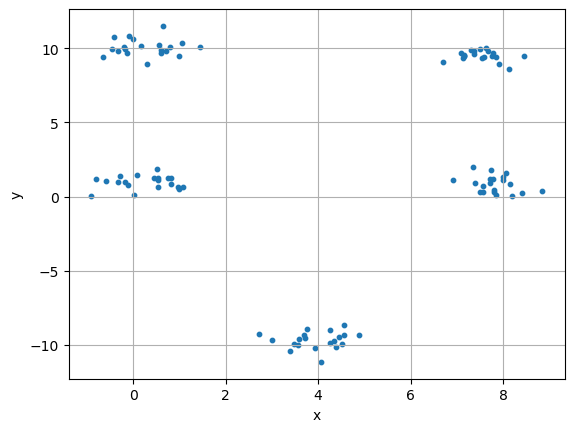

In [3]:
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
subplot.scatter(data_sec1["x"], data_sec1["y"], marker = "o", s = 10)
subplot.grid()
plt.show()

### ステップ4
クラスタリング結果の散布図を表示する関数を定義
* scaler: データの標準化に用いたスケーラ（代表点の逆変換に用いる）
* kmean: クラスタリングに用いたKMeanオブジェクト（代表点の座標の取得に用いる）
* data: クラスタリング対象のデータ
* result: KMeanが出力するクラスタリング結果
* title: 散布図のタイトル
* n_clusters: クラスタ数
* show_centroids: 代表点（重心）を表示するか否か

In [4]:
def show_clustering_result(subplot, scaler, kmean, data, result, n_clusters, show_centroids = True):
    for i in range(n_clusters):
        Ith = data[result == i]
        subplot.scatter(Ith["x"], Ith["y"], color = plt.cm.tab20(i), s = 10, marker = "o", label = "cluster {}".format(i))
    if show_centroids == True:
        centroids = scaler.inverse_transform(kmean.cluster_centers_)
        subplot.scatter(centroids[:,0], centroids[:,1], s=100, marker = "*", color = "white", linewidth = 1, edgecolor = "black", label="centroids")
#    subplot.legend() # 散布図に凡例を示したい場合，コメントアウトを解除
    subplot.grid()

### ステップ5
クラスタリングのためのオブジェクトの定義  
scikit-learn の k平均法ライブラリKMeanを用いて定義し，クラスタリングを行う  
クラスタリングする前にデータを標準化：標準偏差σと平均μを用い，(x - μ)/σ に変換（StandardScalerを利用）  
データを標準化をすることで，単位や分布の相違の影響を削減
* n: 分割するクラスタの数（変更可）
* n_init: 代表点を取り直して計算を繰り返す回数（変更可）
* model: 代表点をランダムに初期設定するモデル（n_init で指定された回数だけ初期設定を繰り返す）

n や n_init の値，読み込むデータ（train1.csv, train2.csv, train3.csv）を変えていろいろ試してみる

In [5]:
n = 3 # クラスタ数
n_init = 10 # 代表点の取り直し回数（ランダムな代表点設定の繰り返しで最も評価の高いものを採用する）

# ランダムな代表点を初期設定するクラスタリングのモデルを定義
scaler = StandardScaler() # 標準偏差と平均を用いてデータを標準化するためのスケーラ
kmeans = KMeans(init = "random", n_clusters = n, n_init = n_init) # 最初の代表点をランダムに取るアルゴリズム
#kmean = KMeans(init = "k-means++", n_clusters = n, n_init = n_init) # 最初の代表点をk-means++で(できるだけばらけるように)取るアルゴリズム
model = Pipeline([
    ("scaler", scaler),
    ("kmeans", kmeans)
])
# 学習させる = クラスタリングを行う
result_sec1 = model.fit_predict(data_sec1)
# このセルを実行すると UserWarning が出ることがあるが無視して良い

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### ステップ6
クラスタリング結果を散布図にして表示（ステップ4で定義した関数を呼び出す）
* 代表点（重心）を☆マークで表示

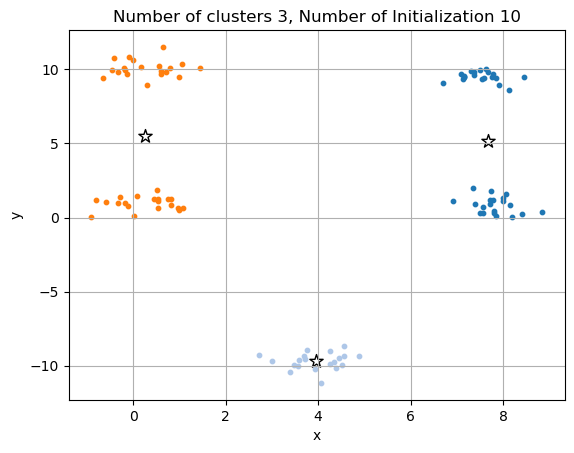

In [6]:
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_title("Number of clusters {}, Number of Initialization {}".format(n, n_init))
subplot.set_xlabel("x")
subplot.set_ylabel("y")
show_clustering_result(subplot, scaler, kmeans, data_sec1, result_sec1, n)
plt.show()

## クラスタリング結果の評価とクラスタ数の検討

### ステップ7
クラスタリング結果の評価
* 二乗歪み（クラスタ内誤差平方和）の値を表示
* この値が小さいほど良いクラスタリングになっている

In [7]:
print("二乗歪み= ", kmeans.inertia_)

二乗歪み=  33.11392401907394


### ステップ8
KMeansオブジェクトについて，クラスタ数を変えて二乗歪みを計算する（1から20クラスタまで）

In [8]:
n_clusters = 20 # 20クラスタまで計算する（変更可）

distortions = [] # 二乗歪みのリスト（空）
for i in range(1, n_clusters + 1):
    kmeans = KMeans(init = "k-means++", n_clusters = i, n_init = 10) # 最初の代表点を k-means++ アルゴリズムで決定する
    #kmeans = KMeans(init = "random", n_clusters = i, n_init = 10) # 最初の代表点をランダムに決定する
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("kmeans", kmeans)
    ])
    model.fit_predict(data_sec1)
    distortions.append(kmeans.inertia_) # 計算した二乗歪みを追加
# このセルを実行すると UserWarning が出ることがあるが無視して良い

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\sit

### ステップ9
結果をグラフ描画する  
二乗歪みの値が改善（減少）しにくくなるあたりが適切なクラスタ数か？

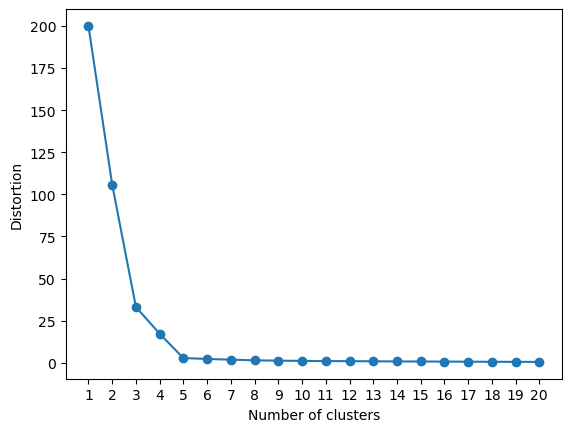

In [9]:
fig = plt.figure()
subplot = fig.add_subplot()
subplot.plot(range(1, n_clusters + 1), distortions, marker = "o")

subplot.set_xlabel("Number of clusters")
subplot.set_ylabel("Distortion")
plt.xticks(range(1, n_clusters + 1))
plt.show()

## k近傍法の処理

### ステップ10
train3.csv からデータ（500個の点）を読み込んでk平均法でクラスタリングし，結果の散布図を表示
* クラスタ数 n は 20とする（いろいろ変更して振舞いを確認すると良い）
* 初期代表点の取り直しは 10 とする

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


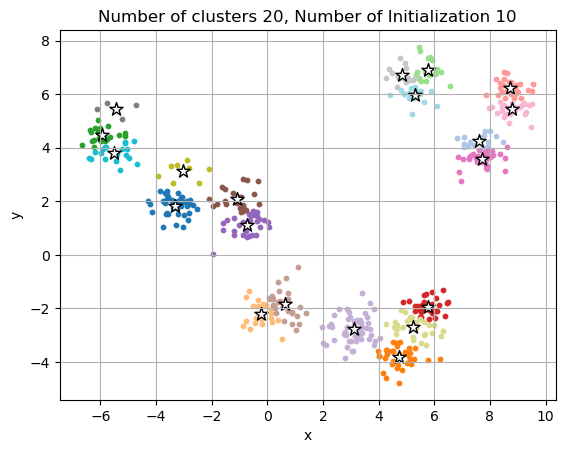

In [10]:
n = 20
data_sec2 = pd.read_csv(Path("03_data", "train3.csv"))
scaler = StandardScaler()
kmeans = KMeans(init = "k-means++", n_clusters = n, n_init = 10)
model = make_pipeline(scaler, kmeans) # 簡易にパイプラインを作成する関数
result_sec2 = model.fit_predict(data_sec2) # 学習・予測
# 結果のグラフ表示
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_title("Number of clusters {}, Number of Initialization {}".format(n, 10))
subplot.set_xlabel("x")
subplot.set_ylabel("y")
show_clustering_result(subplot, scaler, kmeans, data_sec2, result_sec2, n)
plt.show()
# このセルを実行すると UserWarning が出ることがあるが無視して良い

### ステップ11
読み込んだデータとクラスタリング結果を統合し，正解ラベルを含むデータとする  
つまり，ここではk平均法で決めたクラスタを正解ラベルとしている
正解ラベルを含むデータを訓練データとテストデータに分割する

In [11]:
data_sec2["t"] = result_sec2 # result_sec2 に格納された k平均法の結果をデータの t 列として追加
target = DataFrame(data_sec2, columns = ["t"]) # 正解データ（t列）
train = DataFrame(data_sec2, columns = ["x", "y"]) # 訓練対象データ（x, y列）
# 訓練データ（X_train, Y_train）とテストデータ（X_test, Y_test）をランダムに分割
X_train, X_test, Y_train, Y_test = train_test_split(train, target, random_state = 0)
# データの中身を確認したい場合は以下の4行をコメント解除（訓練データ375個とテストデータ125個に分割される）
#print(X_train)
#print(Y_train)
#print(X_test)
#print(Y_test)

### ステップ12
k近傍法の分類器をKNeighborsClassifierオブジェクトを使って定義
* 近傍点の数（k）は 11（変更可能）
* 重み付け方法は単純多数決
* 分類精度（正解個数／全個数）を表示

In [12]:
k = 11 # 近傍点k個を使用
w = "uniform" # 単純多数決
#w = "distance" # 点間の距離で重み付け

# 分類器オブジェクトを作成
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = k, weights = w))
# 訓練データで学習
knn.fit(X_train, Y_train["t"])
# テストデータを分類
Y_pred = knn.predict(X_test)
print("分類精度={}".format(metrics.accuracy_score(Y_test, Y_pred)))

分類精度=0.928


### ステップ13
k近傍法で分類した結果をk平均法のクラスタと重ね合わせて描画
* 大きくて縁の色が黒いものが k近傍法で分類したテストデータ
* 比較対象として k平均法のクラスタリング結果（正解）の散布図を表示
* 分類を間違えた箇所はどこか確認する

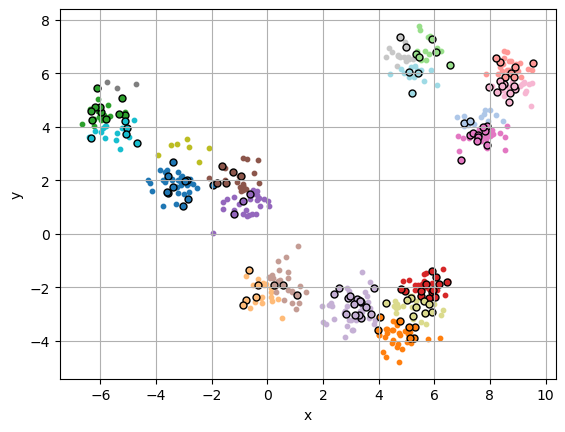

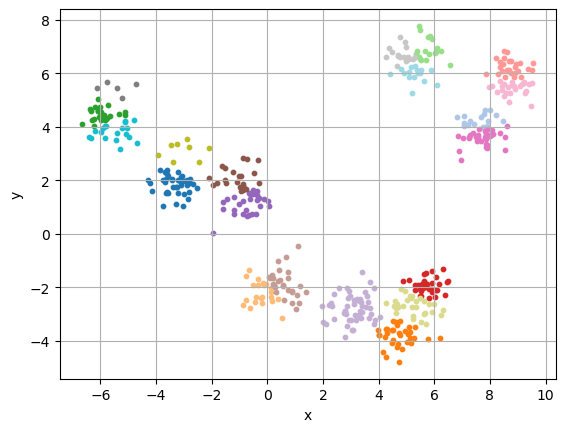

In [13]:
# 訓練データとテストデータに対する分類結果を散布図表示
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
for i in range(n):
    Ith = X_train[Y_train["t"] == i]
    subplot.scatter(Ith["x"], Ith["y"], color = plt.cm.tab20(i), s = 10, marker = "o", label = "cluster {}".format(i))
for i in range(n):
    Ith = X_test[Y_pred == i]
    subplot.scatter(Ith["x"], Ith["y"], color = plt.cm.tab20(i), s = 25, marker = "o", linewidth=1, edgecolor = "black", label = "cluster {}".format(i))
subplot.grid()
plt.show()

# 比較対象としての k平均法のクラスタリング結果表示
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
show_clustering_result(subplot, scaler, kmeans, data_sec2, result_sec2, n, show_centroids = False)
plt.show()

### ステップ14
学習済みのk近傍法分類器が平面上の点をどのように分類するかを色分けして表示  
平面上にメッシュを切り，各座標ごとに分類する（そのたびに全訓練データと比較）ので，分類には時間を要する  
訓練データ（k平均法でのクラスタリング結果）の散布図を重ねて表示

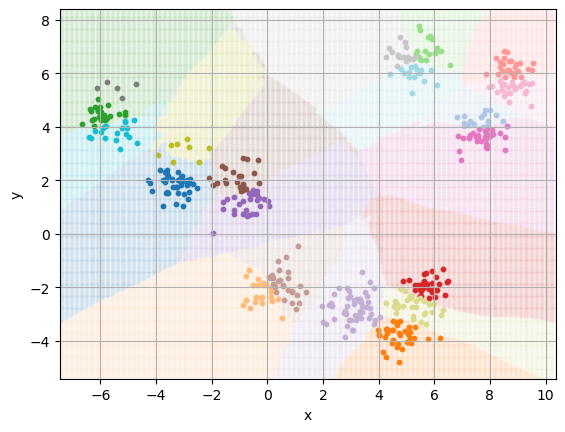

In [14]:
def calculate_plot_range(X): # データの最大・最小に基づいてグラフ描画範囲を決める
    xmin, xmax = X["x"].min(), X["x"].max()
    ymin, ymax = X["y"].min(), X["y"].max()
    return xmin, xmax, ymin, ymax

def show_classification_regions(classifier, subplot, X): # グラフ平面上に，分類領域を色分けして表示
    # グラフをプロットする範囲を計算
    xmin, xmax, ymin, ymax = calculate_plot_range(X)
    # グラフの表示範囲を設定
    xmin, xmax, ymin, ymax = xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin), ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax -ymin)
    subplot.set_xlim(xmin, xmax)
    subplot.set_ylim(ymin, ymax)
    # 予測に与えるサンプルを取るメッシュの解像度（0.0025 * (max - min)）
    xres = 0.0025 * (xmax - xmin)
    yres = 0.0025 * (ymax - ymin)
    xmesh, ymesh = np.meshgrid(np.arange(xmin, xmax, xres), np.arange(ymin, ymax, yres)) # 解像度の間隔で (x, y) のメッシュを作成
    mesh = DataFrame(np.array([xmesh.ravel(), ymesh.ravel()]).T, columns = ["x", "y"]) # 生成したメッシュを一列に並べて分類器に投入
    pred = DataFrame(classifier.predict(mesh), columns = ["t"]) # 作成したメッシュを xの並び，yの並びにして（行列の転置）予測し結果を得る
    # メッシュの点に対する分類結果を散布図として表示
    for i in range(n):
        Ith = mesh[pred["t"] == i]
        subplot.scatter(Ith["x"], Ith["y"], color = plt.cm.tab20(i), alpha = 0.3, s = 0.05, marker = ".")

fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
show_classification_regions(knn, subplot, train)
show_clustering_result(subplot, scaler, kmeans, data_sec2, result_sec2, n, show_centroids = False)
plt.show()

### ステップ15
kの値（近傍を取る個数）がクラスタリングの精度にどのような影響があるかを確かめる
* 同じ訓練データ，テストデータの組に対し，kを1から100まで変化させて精度を記録
* kに対する精度変化のグラフを描画
* 単純多数決の場合と距離重みを用いる場合でkの変化に対する精度の変化について観測

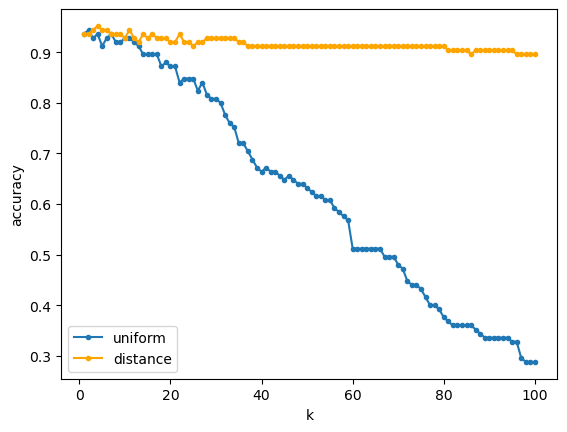

In [15]:
accuracies_uniform = [] # 単純多数決の場合の精度のリスト（空）
accuracies_distance = [] # 距離重みを用いる場合の精度リスト（空）

# 繰り返し分類して精度を記録
for k in range(1, 101):
    knn_u = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = k, weights = "uniform"))
    knn_d = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = k, weights = "distance"))
    knn_u.fit(X_train, Y_train["t"])
    knn_d.fit(X_train, Y_train["t"])
    Y_pred_u = knn_u.predict(X_test)
    Y_pred_d = knn_d.predict(X_test)
    accuracies_uniform.append(metrics.accuracy_score(Y_test, Y_pred_u))
    accuracies_distance.append(metrics.accuracy_score(Y_test, Y_pred_d))

# グラフ描画
fig = plt.figure()
subplot = fig.add_subplot()
subplot.plot(range(1, 101), accuracies_uniform, marker = "o", markersize = 3, label = "uniform")
subplot.plot(range(1, 101), accuracies_distance, color = "orange", marker = "o", markersize = 3, label = "distance")
subplot.set_xlabel("k")
subplot.set_ylabel("accuracy")
subplot.legend()
plt.show()